# Weather forecasting

We will work with convolutional models, including some residual models, for the prediction of surface temperature from a set of atmospheric variables.

It is not expected that the models developed here will be able to do the weather prediction correctly since modeling this with a deep learning model is not a simple task. If you want to know more about deep learning models applied to the field of meteorology and climate you can take a look at [this presentation](https://www.youtube.com/live/QgL-JmbYRp4?si=H_hH0zaBDpCXlKC1&t=2146) (minute 35:36).

In [17]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import keras
from keras import layers
import random
import pandas as pd

Set a seed for reproducibility of the experiments.

In [18]:
from sklearn.utils import check_random_state
seed = 43
np.random.seed(seed)
random.seed(seed)
pd.options.mode.chained_assignment = None
sklearn_random_state = check_random_state(seed)

We are going to work with data from **WeatherBench** [1,2], a dataset that aims to provide researchers with meteorological data to build weather prediction models from deep learning architectures. You can download the data from the following link:

https://drive.google.com/drive/folders/1XnzY8hKWxifR65XFB3ErI_WZMLzzdR_n?usp=sharing

Once downloaded, you can load them as follows (make sure that the `PATH` to the files is correct):

Translated with DeepL.com (free version)

In [ ]:
x_data = np.load('./weatherbench_predictors.npy')
y_data = np.load('./weatherbench_predictand.npy')

The objective of this practice is, from a set of predictors (several meteorological variables) to predict the surface temperature (for the whole globe).The predictors (input) correspond to the data at `x` while the predictand (output) corresponds to the `y`.

In [20]:
print(f'X shape: {x_data.shape} | Y shape: {y_data.shape}')

X shape: (14610, 32, 64, 6) | Y shape: (14610, 32, 64, 1)


The first dimension corresponds to time, we will have data for `14610` days. The second and third dimensions (`32` and `64`) correspond to latitude (height) and longitude (width). These two dimensions can be interpreted in the same way as the height and width of the images we have been working with so far. The fourth dimension is the number of variables. We are going to have `6` different predictors, while only `1` variable for the predictand, the surface temperature (the one we are going to predict).

We will use the following variables as predictors:

In [21]:
predictor_vars = {0: 'Specific humidity at 850 hPa',
                  1: 'Air temperature at 850 hPa',
                  2: 'Geopotential at 850 hPa',
                  3: 'U wind component (10m)',
                  4: 'V wind component (10m)',
                  5: 'Total cloud cover'}

This dictionary maps each dimension of the object `x` with the variable to which it corresponds (e.g., the total cloud cover corresponds to the data `x[:, :, :, :, 5]`).

We can do something similar for the predictand, although in this case we will only have one variable:

In [22]:
predictand_vars = {0: 'Surface (2m) temperature'}

To define time we can do something similar. The data will cover daily data from 1979 to 2018. In this case, for example, 01/01/1979 corresponds to the data `x[0, :, :, :, :, :]`:

In [23]:
start_time = datetime(1979, 1, 1, 12, 0)
end_time   = datetime(2018, 12, 31, 12, 0)
time_step  = timedelta(days=1) 

temporal_dims = {i: start_time + timedelta(days=i) for i in range(0, (end_time - start_time).days + 1)}

Next, for each of the predictor variables, we will plot its time average:

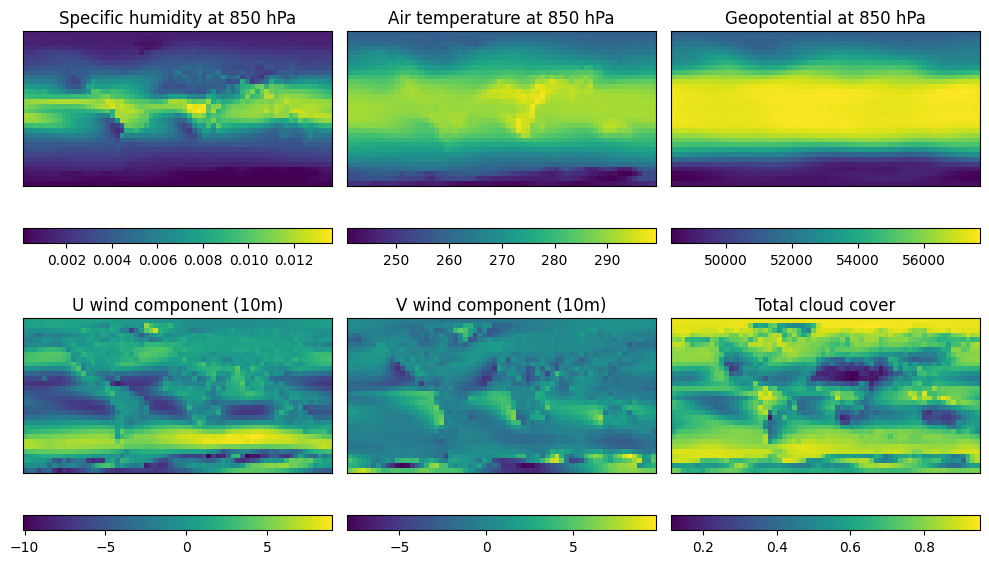

In [24]:
def plot_mean_subplots(data, variable_dims, figsize):

    keys = list(variable_dims.keys())
    n_vars = len(keys)
    
    n = math.ceil(math.sqrt(n_vars))

    if n == 1:
        fig, axes = plt.subplots(n, n, figsize=figsize)
        axes = [axes]
    else:
        fig, axes = plt.subplots(n-1, n, figsize=figsize)
        axes = axes.flatten()

    for idx, key in enumerate(keys):
        arr = data[:, :, :, key]
        mean_val = np.mean(arr, axis=0)
        im = axes[idx].imshow(mean_val, origin='lower')
        axes[idx].set_title(variable_dims[key])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        fig.colorbar(im, ax=axes[idx], orientation='horizontal')

    for i in range(n_vars, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
plot_mean_subplots(data=x_data, variable_dims=predictor_vars, figsize=(10, 6))

These variables are usually considered informative for weather forecasting, below you can find a brief explanation of what each of them represents:

- **Specific humidity at 850 hPa**: Specific humidity at 850 hPa measures the amount of water vapor per kilogram of air at that altitude, approximately 1.5 km above sea level. This value is useful for understanding humidity in the lower atmosphere, which can influence cloud formation and precipitation.
- **Air temperature at 850 hPa**: The air temperature at 850 hPa indicates the heat present in the atmosphere at approximately 1.5 km above sea level. This value is important for assessing atmospheric stability and the formation of meteorological phenomena.
- **Geopotential at 850 hPa**: The geopotential at 850 hPa indicates the height (in meters) at which that level of atmospheric pressure is found, considering the variation of gravity. This value is useful for analyzing the vertical structure of the atmosphere and the circulation of weather systems.
- **U and V wind components (10m)**: The U component of the wind at 10 m indicates the velocity in the east-west direction, and the V component in the north-south direction. Together, they describe the wind direction and intensity at surface level.
- **Total cloud cover**: Total cloud cover indicates the fraction of the sky that is covered by clouds, usually expressed as a percentage. This value is key to understanding the amount of solar radiation that can reach the earth's surface and general weather conditions.

Let us now visualize the variable that we want to predict from these predictors, the surface temperature:

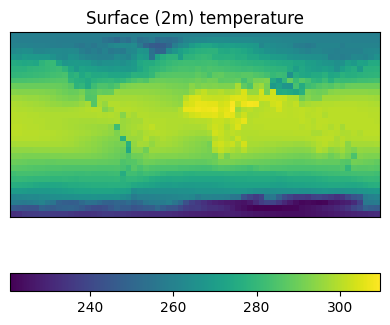

In [25]:
plot_mean_subplots(data=y_data, variable_dims=predictand_vars, figsize=(4, 4))

It is important to note the difference between what we are trying to learn with the deep learning model now compared to the rest of the practices. In this case we are dealing with a regression problem (not classification). The output of the model is going to be an image, not a vector, since we want to predict the surface temperature for one day for the whole globe (the image in the upper cell). Therefore the output of our model (for a specific day) is going to be a matrix with dimension `(1, 32, 64, 1)`.

**Exercise 1** (0.5 points): Create a train partition and a test partition from the data `x` and `y`. The proportions should be 80% and 20%, respectively. Do you think that the appropriate way to make this partition is to randomly select the samples that go to each set? If you can think of another way that fits better with the weather prediction problem, implement it.

**Answer 1:** The best way to partition the dataset into train and test sets is to select records in chronological order. In weather prediction, the data has a temporal structure, so randomly selecting samples can inadvertently allow information from the future to leak into the training phase. Instead, we should use the earlier records for training and the later records for testing. This approach ensures that your model is trained only on past data and then evaluated on future data, which is more reflective of a real forecasting scenario.

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=False)

**Exercise 2** (1 point): Normalize the predictors. Remember that images are normalized by dividing by 255 because that is their natural range, but in this case it is not so. Recall that the min-max normalization formula is:

$x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$

Do you think that in this case one should calculate the minimum and maximum individually for each pixel and variable, or not?

**Answer 2**: No, it's better not to calculate the minimum and maximum for each pixel individually. Instead, you should compute these statistics for each variable across the entire dataset.

In [27]:
min_vals = x_train.min(axis=(0, 1, 2), keepdims=True)
max_vals = x_train.max(axis=(0, 1, 2), keepdims=True)

# Apply the min–max normalization to both training and test sets
x_train_norm = (x_train - min_vals) / (max_vals - min_vals)
x_test_norm = (x_test - min_vals) / (max_vals - min_vals)

print("Normalized training data shape:", x_train_norm.shape)
print("Normalized testing data shape:", x_test_norm.shape)

Normalized training data shape: (11688, 32, 64, 6)
Normalized testing data shape: (2922, 32, 64, 6)


**Exercise 3** (0.5 points): Normally in deep learning models the input (predictors in our case) is normalized but not the output. Why do you think that is?

**Answer 3**: Normalizing inputs helps the model train faster and more reliably by ensuring all features are on a similar scale. This minimizes issues like vanishing or exploding gradients and helps the optimizer converge more effectively. On the other hand, outputs are usually left in their original scale so that predictions remain interpretable and directly comparable to the actual target values.

**Exercise 4** (1 point): Define a first model with an architecture composed exclusively of dense layers. Explain your choice of activation in the last layer. Explain your choice of number of output neurons. Why do you think that in this case a convolutional network fits better than a dense one?

It is important to remember that we want the model's output to have the same dimensions as our `y` (predictand). Therefore, at the end of the model, we will need to add a layer like:

`layers.Reshape((y_train.shape[1:]))`

Why do you think that in this case we should use convolutional layers instead of dense layers?

**Answer 4**: The last layer uses a **linear activation function** because this is a regression problem where we aim to predict continuous values (surface temperature). A linear activation ensures that the output values are not constrained to a specific range (e.g., [0, 1] for sigmoid or [-1, 1] for tanh), allowing the model to predict any real-valued temperature.

The number of output neurons is set to `32 * 64` because the target output is a 2D grid (32x64) representing the surface temperature for the entire globe. After this, the `Reshape` layer reshapes the output into the desired shape `(32, 64, 1)` to match the dimensions of `y_train`.

A convolutional network fits better because:
1. is designed to capture spatial patterns and relationships in data. In this case, the predictors and target variables are spatially structured (latitude and longitude), making CNNs more suitable for learning these patterns.

2. dense layers treat all input features as independent, leading to a large number of parameters. CNNs, on the other hand, use shared weights (kernels) to process local regions, significantly reducing the number of parameters and improving computational efficiency.

3. CNNs are inherently translation-invariant, meaning they can recognize patterns regardless of their position in the input. This property is crucial for weather data, where patterns like temperature gradients or cloud formations can appear in different locations.

In [28]:
# Define the model using only dense layers
dense_model = keras.Sequential([
    layers.InputLayer(input_shape=(32, 64, 6)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.3, seed=seed),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.3, seed=seed),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dense(32 * 64, activation='linear'),
    layers.Reshape(y_train.shape[1:])
])

dense_model.compile(optimizer='adam', loss='mse')

dense_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3145984   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 2048)             

In [29]:
# Train the model
dense_history = dense_model.fit(x_train_norm, y_train, epochs=20, batch_size=32, validation_data=(x_test_norm, y_test))

Epoch 1/20
366/366 [==============================] - 3s 9ms/step - loss: 3429.6951 - val_loss: 2234.7856
Epoch 2/20
366/366 [==============================] - 3s 8ms/step - loss: 644.0753 - val_loss: 4360.4795
Epoch 3/20
366/366 [==============================] - 3s 8ms/step - loss: 515.0803 - val_loss: 8402.4961
Epoch 4/20
366/366 [==============================] - 3s 8ms/step - loss: 401.6540 - val_loss: 13103.8975
Epoch 5/20
366/366 [==============================] - 3s 7ms/step - loss: 284.1554 - val_loss: 14981.9922
Epoch 6/20
366/366 [==============================] - 3s 7ms/step - loss: 222.9643 - val_loss: 15785.4795
Epoch 7/20
366/366 [==============================] - 3s 7ms/step - loss: 184.0040 - val_loss: 17605.6660
Epoch 8/20
366/366 [==============================] - 3s 7ms/step - loss: 154.6542 - val_loss: 17808.9902
Epoch 9/20
366/366 [==============================] - 3s 7ms/step - loss: 130.1694 - val_loss: 20013.0059
Epoch 10/20
366/366 [===========================

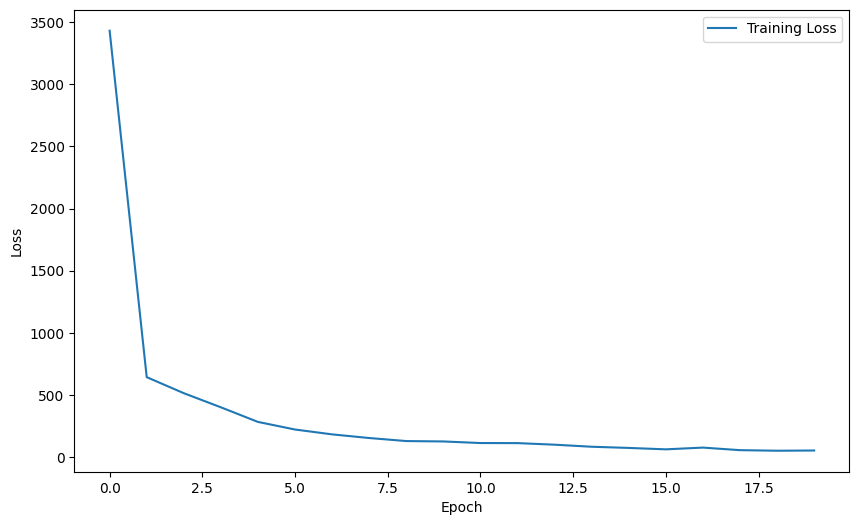

In [ ]:
# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(dense_history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise 5 (1 point)

### Task Description

Design a simple convolutional model using only `layers.Conv2D`. What is the difference in the number of parameters compared to the dense model? Train it for several epochs. Justify your choice of loss function.

In this case, we do not need to use `layers.Reshape` since we are not using dense layers. The only requirement is to ensure that the convolutional layers do not reduce the spatial dimensions by setting the argument `padding='same'`. This way, we only need to adjust the number of *filters* in the last layer so that the model's output has the shape `(:, 32, 64, 1)`.


In [39]:
# CNN model
cnn_model = keras.Sequential([
    layers.InputLayer(input_shape=(32, 64, 6)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(1, 3, activation='linear', padding='same') 
])

cnn_model.compile(optimizer='adam', loss='mse')

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 64, 32)        1760      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 64, 1)         577       
                                                                 
Total params: 20833 (81.38 KB)
Trainable params: 20833 (81.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


For this regression problem, the **Mean Squared Error (MSE)** loss function is chosen because:

1. The target variable (surface temperature) is continuous, and MSE is well-suited for regression tasks where the goal is to minimize the difference between predicted and actual values.

2. MSE penalizes larger errors more heavily due to the squaring of differences.


In [42]:
params_dense = dense_model.count_params()
params_cnn = cnn_model.count_params()
print(f"Number of parameters in Dense model: {params_dense}")
print(f"Number of parameters in CNN model: {params_cnn}")
if params_dense > params_cnn:
    print(f"Dense model has {params_dense - params_cnn} more parameters than CNN model.")
else:
    print(f"CNN model has {params_cnn - params_dense} more parameters than Dense model.")

Number of parameters in Dense model: 3508864
Number of parameters in CNN model: 20833
Dense model has 3488031 more parameters than CNN model.


In [51]:
# Train the model
cnn_history = cnn_model.fit(x_train_norm, y_train, epochs=10, batch_size=32, validation_data=(x_test_norm, y_test))

Epoch 1/10
366/366 [==============================] - 26s 70ms/step - loss: 41.0284 - val_loss: 40.6603
Epoch 2/10
366/366 [==============================] - 25s 67ms/step - loss: 39.1244 - val_loss: 38.8192
Epoch 3/10
366/366 [==============================] - 25s 69ms/step - loss: 37.6715 - val_loss: 37.3623
Epoch 4/10
366/366 [==============================] - 28s 76ms/step - loss: 36.2870 - val_loss: 36.8840
Epoch 5/10
366/366 [==============================] - 27s 73ms/step - loss: 35.1292 - val_loss: 34.9075
Epoch 6/10
366/366 [==============================] - 26s 72ms/step - loss: 34.1987 - val_loss: 34.2986
Epoch 7/10
366/366 [==============================] - 26s 72ms/step - loss: 32.9528 - val_loss: 33.1586
Epoch 8/10
366/366 [==============================] - 26s 72ms/step - loss: 31.6373 - val_loss: 31.7505
Epoch 9/10
366/366 [==============================] - 28s 76ms/step - loss: 30.6661 - val_loss: 35.1023
Epoch 10/10
366/366 [==============================] - 30s 81ms/

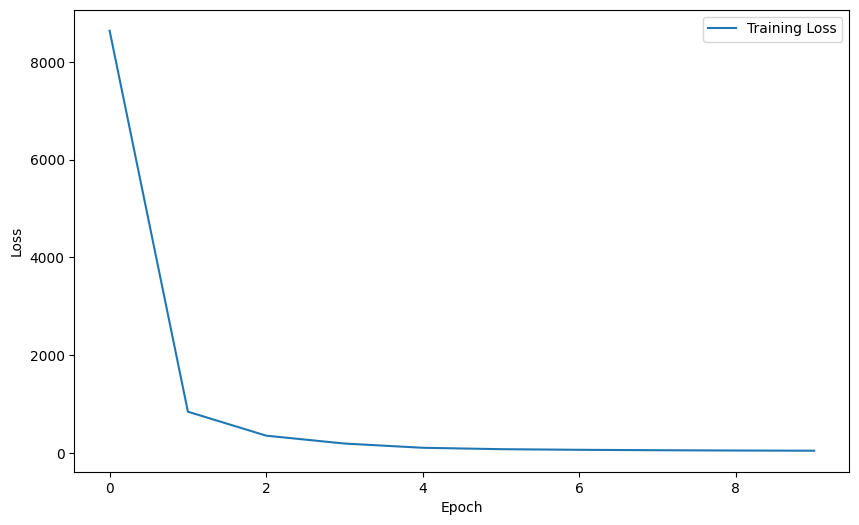

In [43]:
# plot the training history
plt.figure(figsize=(10, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Exercise 6** (1 point): Compute the predictions for the test period and evaluate the results using an evaluation metric (e.g., RMSE or MAE). If possible, also compute these metrics at the pixel level so that we can visualize an image of the globe where each pixel represents the result of applying that metric to that pixel.

In [54]:
y_pred = cnn_model.predict(x_test_norm)

92/92 [==============================] - 2s 17ms/step


RMSE (Global): 5.43527364730835
MAE (Global): 3.895552635192871
RMSE (Pixel-wise):


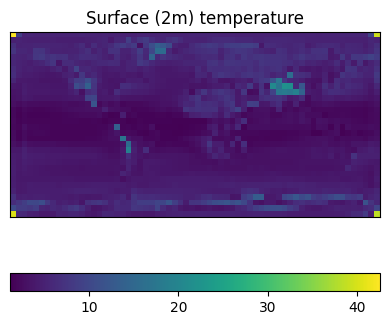

MAE (Pixel-wise):


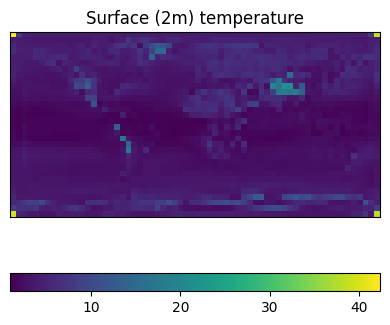

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE and MAE for the entire test set
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())

print(f"RMSE (Global): {rmse}")
print(f"MAE (Global): {mae}")

# Compute pixel-wise RMSE and MAE
rmse_pixel = np.sqrt(np.mean((y_test - y_pred) ** 2, axis=0))
mae_pixel = np.mean(np.abs(y_test - y_pred), axis=0)

rmse_pixel = np.expand_dims(rmse_pixel, axis=0)  # Now shape becomes (1, 32, 64, 1)
mae_pixel = np.expand_dims(mae_pixel, axis=0)


print("RMSE (Pixel-wise):")
plot_mean_subplots(data=rmse_pixel, variable_dims=predictand_vars, figsize=(4, 4))
print("MAE (Pixel-wise):")
plot_mean_subplots(data=mae_pixel, variable_dims=predictand_vars, figsize=(4, 4))

In the corners of the image, higher error values are observed because predictions at the boundaries tend to suffer from a lack of contextual information. When the model makes predictions near the edges, it has access to less neighboring data compared to predictions made in the central regions. This reduced context limits the model's ability to accurately infer patterns and dependencies, leading to greater uncertainty and higher error values in those areas.


**Exercise 7** (0.5 points): Write a function that allows us to compare the prediction for a specific day against the actual value in the test period. It is not necessary to index the data by date; indexing through indices (`0:14610`) is sufficient.

Actual temporature:


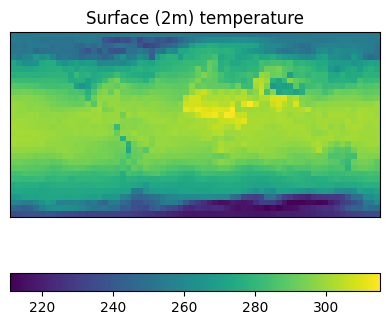

Predicted temperature:


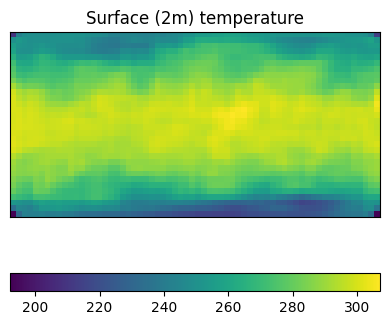

In [74]:
def compare_prediction(index, y_pred):
    """
    Compare the predicted and actual values for a specific day in the test period.
    """
    if index < 0 or index >= y_test.shape[0]:
        print("Index out of range. Please provide a valid index.")
        return

    actual = y_test[index, :, :, 0]
    predicted = y_pred[index, :, :, 0]
    
    # expand dimensions to match the expected shape (1, 32, 64, 1)
    actual = np.expand_dims(actual, axis=0)
    predicted = np.expand_dims(predicted, axis=0)
    actual = np.expand_dims(actual, axis=-1)
    predicted = np.expand_dims(predicted, axis=-1)

    print("Actual temporature:")
    plot_mean_subplots(data=actual, variable_dims=predictand_vars, figsize=(4, 4))
    print("Predicted temperature:")
    plot_mean_subplots(data=predicted, variable_dims=predictand_vars, figsize=(4, 4))

compare_prediction(100, y_pred)  

**Exercise 8** (1 point): Design and train a more complex convolutional model using the elements covered in the previous practice (e.g., with Batch Normalization). If necessary, modify the optimization algorithm or add some form of regularization.

In [72]:
complex_cnn_model = keras.Sequential([
    layers.InputLayer(input_shape=(32, 64, 6)),
    
    # First convolutional block
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3, seed=seed),
    
    # Second convolutional block
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3, seed=seed),
    
    # Third convolutional block
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.UpSampling2D(size=(2, 2)),
    layers.Dropout(0.3, seed=seed),
    
    # Fourth convolutional block
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.UpSampling2D(size=(2, 2)),
    layers.Dropout(0.3, seed=seed),
    
    # Output layer
    layers.Conv2D(1, 3, activation='linear', padding='same')
])

complex_cnn_model.compile(optimizer='adam', loss='mse')

complex_cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 64, 32)        1760      
                                                                 
 batch_normalization (Batch  (None, 32, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 32, 32)        0         
 D)                                                              
                                                      

In [73]:
complex_cnn_history = complex_cnn_model.fit(x_train_norm, y_train, epochs=10, batch_size=32, validation_data=(x_test_norm, y_test))

Epoch 1/10
366/366 [==============================] - 75s 203ms/step - loss: 54087.7812 - val_loss: 19637.5762
Epoch 2/10
366/366 [==============================] - 75s 206ms/step - loss: 4107.2363 - val_loss: 506.7504
Epoch 3/10
366/366 [==============================] - 82s 223ms/step - loss: 409.3781 - val_loss: 231.6229
Epoch 4/10
366/366 [==============================] - 105s 286ms/step - loss: 308.3860 - val_loss: 129.2814
Epoch 5/10
366/366 [==============================] - 112s 307ms/step - loss: 240.9761 - val_loss: 81.4078
Epoch 6/10
366/366 [==============================] - 105s 286ms/step - loss: 202.6347 - val_loss: 80.3215
Epoch 7/10
366/366 [==============================] - 102s 277ms/step - loss: 177.4221 - val_loss: 49.7842
Epoch 8/10
366/366 [==============================] - 120s 327ms/step - loss: 160.0434 - val_loss: 40.8844
Epoch 9/10
366/366 [==============================] - 116s 317ms/step - loss: 147.5814 - val_loss: 40.6130
Epoch 10/10
366/366 [==========

**Exercise 9** (0.5 points): Evaluate the model and compare it with the previous one. Have you achieved any improvement? If so, why do you think that is? Do you observe any particular pattern in the spatial distribution of the error? For the evaluation, you can use the code developed in Exercises 6 and 7.

In [75]:
y_pred_complex = complex_cnn_model.predict(x_test_norm)

92/92 [==============================] - 5s 54ms/step


RMSE (Global): 5.43527364730835
MAE (Global): 3.895552635192871
RMSE (Pixel-wise):


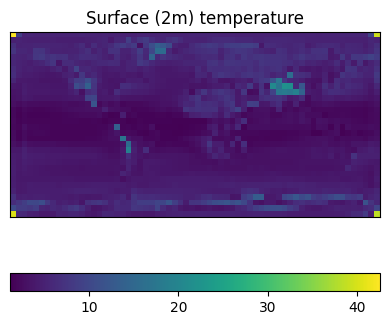

MAE (Pixel-wise):


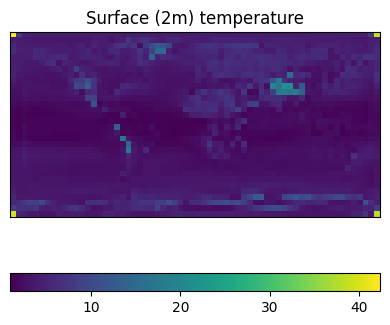

In [ ]:
# Compute RMSE and MAE for the entire test set
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())

print(f"RMSE (Global): {rmse}")
print(f"MAE (Global): {mae}")

# Compute pixel-wise RMSE and MAE
rmse_pixel = np.sqrt(np.mean((y_test - y_pred) ** 2, axis=0))
mae_pixel = np.mean(np.abs(y_test - y_pred), axis=0)

rmse_pixel = np.expand_dims(rmse_pixel, axis=0) 
mae_pixel = np.expand_dims(mae_pixel, axis=0)


print("RMSE (Pixel-wise):")
plot_mean_subplots(data=rmse_pixel, variable_dims=predictand_vars, figsize=(4, 4))
print("MAE (Pixel-wise):")
plot_mean_subplots(data=mae_pixel, variable_dims=predictand_vars, figsize=(4, 4))


Actual temporature:


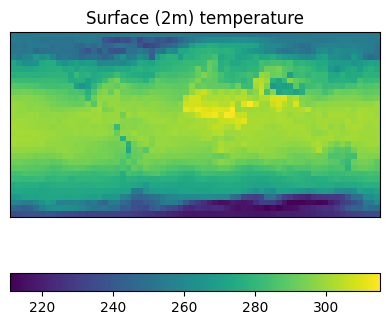

Predicted temperature:


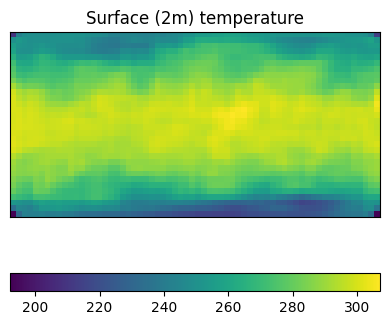

In [80]:
compare_prediction(100, y_pred)  

**Exercise 10** (1.5 points): To improve the predictions, we will implement a residual model, specifically DenseNet [3]. Implement the following model, following what was covered in class (and in the corresponding notebook). In this model, BN corresponds to Batch Normalization:

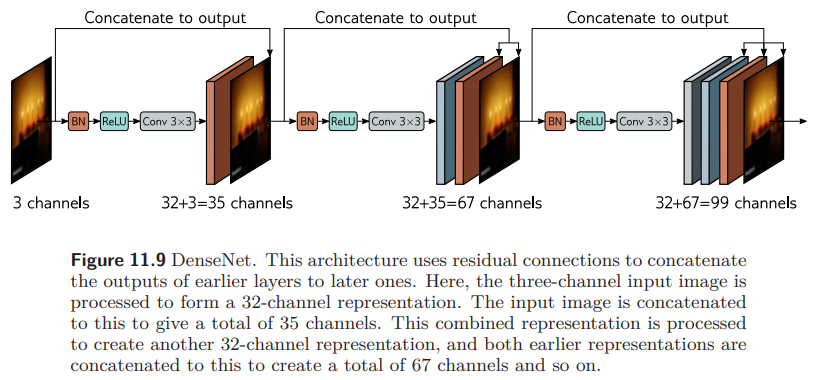

You can decide what to place in the last layer after the third residual block. In our case, instead of 3 input channels, remember that we have 6. Try to write the model in a compact and functional way (use the residual model implemented in class as a reference). Train and evaluate the predictions on the test period.

In [82]:
def residual_block(x, filters):
    """
    A 'dense' block consisting of:
      1) Batch Normalization
      2) ReLU
      3) Conv2D
      4) Concatenate input (x) with the new output
    """
    out = layers.BatchNormalization()(x)
    out = layers.ReLU()(out)
    out = layers.Conv2D(filters, kernel_size=3, padding='same')(out)
    out = layers.Concatenate()([x, out])
    return out

# Define the DenseNet-inspired residual model
input_layer = layers.Input(shape=(32, 64, 6))

x = residual_block(input_layer, 32)
x = residual_block(x, 32)
x = residual_block(x, 32)

output_layer = layers.Conv2D(1, kernel_size=3, padding='same', activation='linear')(x)

residual_model = keras.Model(inputs=input_layer, outputs=output_layer)
residual_model.compile(optimizer='adam', loss='mse')
residual_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 64, 6)]          0         []                            
                                                                                                  
 batch_normalization_23 (Ba  (None, 32, 64, 6)            24        ['input_6[0][0]']             
 tchNormalization)                                                                                
                                                                                                  
 re_lu (ReLU)                (None, 32, 64, 6)            0         ['batch_normalization_23[0][0]
                                                                    ']                            
                                                                                            

In [83]:
# train the model
residual_history = residual_model.fit(x_train_norm, y_train, epochs=10, batch_size=32)

Epoch 1/10
366/366 [==============================] - 70s 185ms/step - loss: 5286.2124
Epoch 2/10
366/366 [==============================] - 66s 179ms/step - loss: 229.2741
Epoch 3/10
366/366 [==============================] - 71s 193ms/step - loss: 80.6623
Epoch 4/10
366/366 [==============================] - 92s 250ms/step - loss: 59.6785
Epoch 5/10
366/366 [==============================] - 84s 230ms/step - loss: 51.6547
Epoch 6/10
366/366 [==============================] - 84s 230ms/step - loss: 46.6554
Epoch 7/10
366/366 [==============================] - 89s 244ms/step - loss: 42.6191
Epoch 8/10
366/366 [==============================] - 86s 236ms/step - loss: 39.2892
Epoch 9/10
366/366 [==============================] - 87s 237ms/step - loss: 36.3226
Epoch 10/10
366/366 [==============================] - 88s 241ms/step - loss: 33.6082


In [84]:
y_pred = residual_model.predict(x_test_norm)

92/92 [==============================] - 6s 61ms/step


RMSE (Global): 6.019896984100342
MAE (Global): 4.273021697998047
RMSE (Pixel-wise):


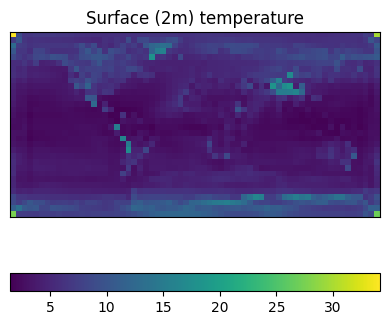

MAE (Pixel-wise):


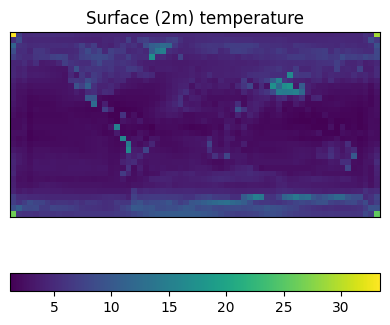

In [86]:
# Compute RMSE and MAE for the entire test set
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())

print(f"RMSE (Global): {rmse}")
print(f"MAE (Global): {mae}")

# Compute pixel-wise RMSE and MAE
rmse_pixel = np.sqrt(np.mean((y_test - y_pred) ** 2, axis=0))
mae_pixel = np.mean(np.abs(y_test - y_pred), axis=0)

rmse_pixel = np.expand_dims(rmse_pixel, axis=0) 
mae_pixel = np.expand_dims(mae_pixel, axis=0)


print("RMSE (Pixel-wise):")
plot_mean_subplots(data=rmse_pixel, variable_dims=predictand_vars, figsize=(4, 4))
print("MAE (Pixel-wise):")
plot_mean_subplots(data=mae_pixel, variable_dims=predictand_vars, figsize=(4, 4))

Actual temporature:


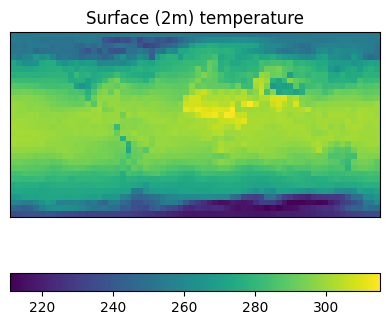

Predicted temperature:


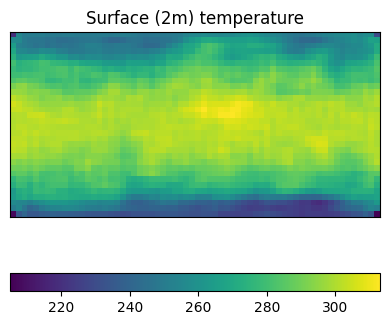

In [85]:
compare_prediction(100, y_pred)  

**Exercise 11** (1.5 points): To complete the practice, we will train a U-Net architecture (as seen in class). First, we need to modify the input and output data of the model since, although possible, U-Net was initially designed to process square images with a number of pixels proportional to a power of 2. Therefore, we will transform both the predictors and the target variable as follows:

In [87]:
x_data_unet, y_data_unet = x_data[:, :, :32, :], y_data[:, :, :32, :]

In [88]:
print(f'X_unet shape: {x_data_unet.shape} | Y_unet shape: {y_data_unet.shape}')

X_unet shape: (14610, 32, 32, 6) | Y_unet shape: (14610, 32, 32, 1)


This way, we focus on the domain covering America with a number of pixels in latitude and longitude equal to $2^5=32$:



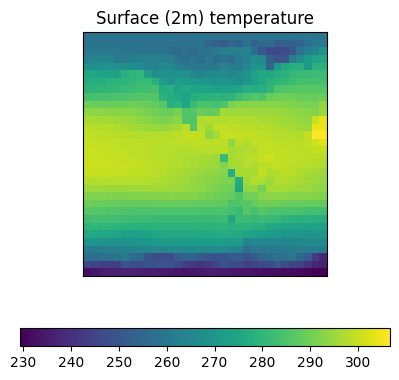

In [89]:
plot_mean_subplots(data=y_data_unet, variable_dims=predictand_vars, figsize=(4, 4))

Remember that before training the model, it is necessary to split the data into train and test sets again and normalize the data. You can reuse the code from previous exercises.

In [90]:
x_train_unet, x_test_unet, y_train_unet, y_test_unet = train_test_split(
    x_data_unet, y_data_unet, test_size=0.2, random_state=42, shuffle=False
)

print(f"x_train_unet shape: {x_train_unet.shape} | x_test_unet shape: {x_test_unet.shape}")
print(f"y_train_unet shape: {y_train_unet.shape} | y_test_unet shape: {y_test_unet.shape}")

x_train_unet shape: (11688, 32, 32, 6) | x_test_unet shape: (2922, 32, 32, 6)
y_train_unet shape: (11688, 32, 32, 1) | y_test_unet shape: (2922, 32, 32, 1)


Design and train a U-Net model. In this case, the number of input and output channels is not the same, so keep this in mind. Variations from the model presented in class will be positively evaluated. Train and evaluate the model.

In [95]:
# Define a lighter U-Net model
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Concatenate()([up4, conv2])
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Concatenate()([up5, conv1])
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(up5)

    outputs = layers.Conv2D(1, 1, activation='linear')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the lighter U-Net model
unet = unet_model(input_shape=(32, 32, 6))
unet.compile(optimizer='adam', loss='mse')

unet.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 32, 32, 6)]          0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 32, 32, 32)           1760      ['input_10[0][0]']            
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_59[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_60 (Conv2D)          (None, 16, 16, 64)           18496     ['max_pooling2d_9[0][0]'

In [96]:
unet_history = unet.fit(x_train_unet, y_train_unet, epochs=10, batch_size=32, validation_data=(x_test_unet, y_test_unet))

Epoch 1/10
366/366 [==============================] - 33s 89ms/step - loss: 1278574.0000 - val_loss: 1034.7676
Epoch 2/10
366/366 [==============================] - 32s 88ms/step - loss: 784.9137 - val_loss: 664.0057
Epoch 3/10
366/366 [==============================] - 33s 90ms/step - loss: 545.5165 - val_loss: 510.3002
Epoch 4/10
366/366 [==============================] - 34s 92ms/step - loss: 444.7355 - val_loss: 438.1800
Epoch 5/10
366/366 [==============================] - 40s 110ms/step - loss: 382.4413 - val_loss: 352.1935
Epoch 6/10
366/366 [==============================] - 54s 147ms/step - loss: 344.1133 - val_loss: 298.7440
Epoch 7/10
366/366 [==============================] - 50s 137ms/step - loss: 318.5691 - val_loss: 272.6284
Epoch 8/10
366/366 [==============================] - 50s 136ms/step - loss: 314.6989 - val_loss: 415.6322
Epoch 9/10
366/366 [==============================] - 49s 134ms/step - loss: 279.4135 - val_loss: 665.9376
Epoch 10/10
366/366 [===============

In [98]:
y_pred = unet.predict(x_test_unet)

92/92 [==============================] - 3s 31ms/step


RMSE (Global): 19.138938903808594
MAE (Global): 15.640840530395508
RMSE (Pixel-wise):


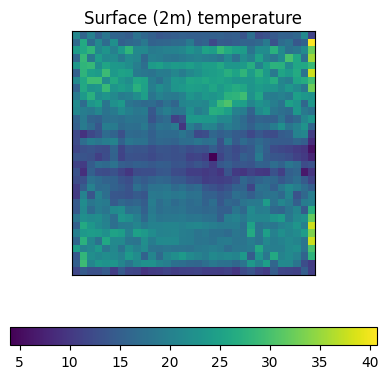

MAE (Pixel-wise):


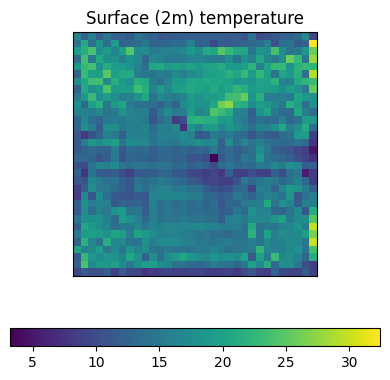

In [99]:
rmse = np.sqrt(mean_squared_error(y_test_unet.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_test_unet.flatten(), y_pred.flatten())
print(f"RMSE (Global): {rmse}")
print(f"MAE (Global): {mae}")
# Compute pixel-wise RMSE and MAE
rmse_pixel = np.sqrt(np.mean((y_test_unet - y_pred) ** 2, axis=0))
mae_pixel = np.mean(np.abs(y_test_unet - y_pred), axis=0)
rmse_pixel = np.expand_dims(rmse_pixel, axis=0)
mae_pixel = np.expand_dims(mae_pixel, axis=0)
print("RMSE (Pixel-wise):")
plot_mean_subplots(data=rmse_pixel, variable_dims=predictand_vars, figsize=(4, 4))
print("MAE (Pixel-wise):")
plot_mean_subplots(data=mae_pixel, variable_dims=predictand_vars, figsize=(4, 4))

### References

**[1]** Rasp, S., Dueben, P. D., Scher, S., Weyn, J. A., Mouatadid, S., & Thuerey, N. (2020). WeatherBench: a benchmark data set for data‐driven weather forecasting. Journal of Advances in Modeling Earth Systems, 12(11), e2020MS002203.

**[2]** Rasp, S., Hoyer, S., Merose, A., Langmore, I., Battaglia, P., Russell, T., ... & Sha, F. (2024). WeatherBench 2: A benchmark for the next generation of data‐driven global weather models. Journal of Advances in Modeling Earth Systems, 16(6), e2023MS004019.

**[3]** Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708).

**[4]** Prince, S. J. (2023). *Understanding deep learning*. MIT press.